In [1]:
import pandas as pd
import datetime
import holidays
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

In [2]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
dati = pd.read_csv(r'Dati_PUN_17-20.csv', parse_dates = ['Data'])
sinusoidi = pd.read_csv(r'sinusoidi2.csv')

In [4]:
dati['Giorno'] = dati['Data'].apply(lambda x: x.date().strftime('%A'))

In [5]:
def get_holiday(row):
    row = row.date()
    iatly_holidays = holidays.Italy(years = [2017, 2018, 2019, 2020])
    if row in iatly_holidays:
        return(1)
    else:
        return(0)    

In [6]:
dati['Giorno_Vacanza'] = dati['Data'].apply(get_holiday)

In [7]:
dummies = pd.get_dummies(dati['Giorno'])

In [8]:
frames = [dati, dummies, sinusoidi]

In [9]:
dati = pd.concat(frames, axis = 1)

In [10]:
dati = dati.drop(columns = ['Giorno'])

In [11]:
dati["df24"] = dati['PUN'].shift(24)

In [12]:
train = dati[24:26112]
test = dati[26112:]
train = train.drop(columns = ['Data'])
test = test.drop(columns = ['Data'])

In [13]:
# creating the final variables for training the model and then validating it

X_train = train.drop("PUN", axis=1).values
X_test = test.drop("PUN", axis=1).values
y_train = train['PUN'].values
y_test = test["PUN"].values

In [14]:
from sklearn.linear_model import ElasticNet

In [15]:
parameters = {'alpha':[0.5, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.9, 1, 1.1, 1.2, 1.25, 1.3],
             'l1_ratio':[0.1, 0.2, 0.25,0.3, 0.35, 0.4, 0.5, 0.7, 0.8, 1, 1.2, 1.4],
             'max_iter':[100000], 'tol':[0.0000000000000001],
             'warm_start':'True'}

In [16]:
reg = ElasticNet()
reg_grid =RandomizedSearchCV(estimator=reg,  
                     param_distributions=parameters,
                     scoring='r2',
                     cv=5, n_iter = 5)

In [17]:
regr = reg_grid.fit(X_train, y_train)

In [18]:
print(reg_grid.best_estimator_)

ElasticNet(alpha=0.6, copy_X=True, fit_intercept=True, l1_ratio=0.4,
           max_iter=100000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=1e-16, warm_start='u')


In [35]:
predicted=regr.predict(X_test)

In [36]:
predicted_shifted = pd.Series(predicted).shift(-24)

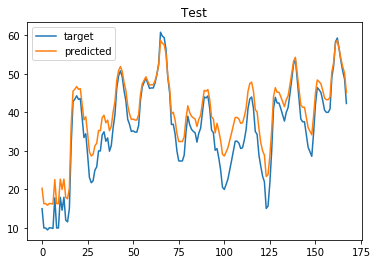

In [49]:
plt.plot(y_test[:168], label = "target")
plt.plot(predicted_shifted, label = "predicted")
plt.legend()
plt.title('Test')
plt.savefig("ElasticTest.png")

In [22]:
from sklearn.metrics import mean_absolute_error

In [42]:
print('MAE: ', mean_absolute_error(predicted_shifted[:168], y_test[:168]))
print('MAPE: ', mean_absolute_percentage_error(y_test[:168], predicted_shifted[:168]))

MAE:  3.8837680130353727
MAPE:  15.563082451199826


In [43]:
train_pred = regr.predict(X_train)

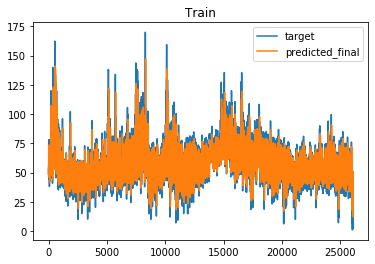

In [50]:
plt.plot(y_train, label = "target")
plt.plot(train_pred, label = "predicted_final")
plt.legend()
plt.title('Train')
plt.savefig("ElasticTrain.png")

In [45]:
print('MAE: ', mean_absolute_error(y_train, train_pred))
print('MAPE: ', mean_absolute_percentage_error(y_train, train_pred))

MAE:  6.248773973458225
MAPE:  12.323497763786111
